In [1]:
import warnings
from sklearn.preprocessing import normalize
import librosa.display
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
# import pydotplus
import seaborn as sns
import sklearn
import sys

# from graphviz import Source
from pandarallel import pandarallel
from sklearn.model_selection import train_test_split #, GridSearchCV, learning_curve
# from sklearn.metrics import classification_report, plot_confusion_matrix, mean_squared_error
# from sklearn.tree import DecisionTreeClassifier, export_graphviz
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.neural_network import MLPClassifier

from os import listdir, path
from os.path import isfile, join

# Python ≥3.5 is required
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
assert sklearn.__version__ >= "0.20"

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('fivethirtyeight')

# to make this notebook's output stable across runs
np.random.seed(42)

# import joblib
# import pickle
warnings.filterwarnings('ignore')

RESULTS_PATH = os.path.join('./results')

# os.environ['LIBROSA_CACHE_DIR'] = '/tmp/librosa_cache'
import librosa

%matplotlib inline
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
genre_folder = '../MLP2/rawdata/genres'
genre_names = [f for f in listdir(
    path=genre_folder) if not isfile(join(genre_folder, f))]

SAMPLE_RATE = 45600

time_series_data, labels = [], []
i = 0

song_paths = []
maxlen = 0
for g in genre_names:
    p = genre_folder + '/' + g  # path for a genre folder
    for song in sorted(listdir(path=p)):  # song at index 0 for each folder
        song_paths.append(p + '/' + song)
        time_series, sample_rate = librosa.load(
            Path(song_paths[-1], duration=60, sr=SAMPLE_RATE))
        t = np.array(time_series)
        maxlen = len(t) if len(t) > maxlen else maxlen
        time_series_data.append(t)
        labels.append(g)
        i += 0

In [3]:
# for i in range(len(time_series_data)):
#     tmp = np.zeros(shape=(maxlen,))
#     l = len(time_series_data[i])
#     tmp[0:l] = np.array(time_series_data[i])
#     tmp = time_series_data[i].reshape(maxlen,)
#     time_series_data[i] = tmp  

In [4]:
# [len(time_series_data[i]) for i in range(15)]


In [5]:
# song_df.time_series[0]

# 2D CNN

In [6]:
# method to pad and reshape the feature arrays
# xx: height of output
# yy: width of output
def padding(array, xx, yy):
    h = array.shape[0]
    w = array.shape[1]
    a = max((xx - h) // 2, 0)
    aa = max(0, xx - a - h)
    b = max(0, (yy - w) // 2)
    bb = max(yy - b - w, 0)
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')


In [7]:
# method to extract and format the features to be used for a Conv2D model
# 
def generate_features(time_series):
    max_size = 1320  # max audio file feature width
    n_fft = 255
    hop_length = 512
    

    # short-time fourier transform
    stft = padding(
        np.abs(normalize(abs(librosa.stft(time_series, n_fft=255, hop_length=512)))), 128, max_size)

    MFCCs = padding(normalize(librosa.feature.mfcc(time_series, n_fft=n_fft,
                                                hop_length=hop_length, n_mfcc=128)), 128, max_size)
    spec_centroid = normalize(librosa.feature.spectral_centroid(
        y=time_series, sr=SAMPLE_RATE))
    chroma_stft = normalize(librosa.feature.chroma_stft(
        y=time_series, sr=SAMPLE_RATE))
    spec_bw = normalize(librosa.feature.spectral_bandwidth(
        y=time_series, sr=SAMPLE_RATE))

    #Now the padding part
    image = np.array([padding(normalize(spec_bw), 1, max_size)]
                    ).reshape(1, max_size)
    image = np.append(image, padding(
        normalize(spec_centroid), 1, max_size), axis=0)

    padded_spec_bw = padding(
        normalize(spec_bw), 1, max_size)
    padded_spec = padding(
        normalize(spec_centroid), 1, max_size)
    padded_chroma = padding(
        normalize(chroma_stft), 12, max_size)

    #repeat the padded spec_bw,spec_centroid and chroma stft until they are stft and MFCC-sized
    for i in range(0, 9):
        image = np.append(image, padded_spec_bw, axis=0)
        image = np.append(image, padded_spec, axis=0)
        image = np.append(image, padded_chroma, axis=0)

    image = np.dstack((image, np.abs(stft)))
    image = np.dstack((image, MFCCs))
    return image

In [8]:
# time_series = time_series_data[0]
# max_size = 1320  # max audio file feature width
# n_fft = 255
# hop_length = 512

# # short-time fourier transform
# stft = padding(
#     np.abs(normalize(abs(librosa.stft(time_series, n_fft=255, hop_length=512)))), 128, max_size)

# MFCCs = padding(normalize(librosa.feature.mfcc(time_series, n_fft=n_fft,
#                                      hop_length=hop_length, n_mfcc=128)), 128, max_size)
# spec_centroid = normalize(librosa.feature.spectral_centroid(
#     y=time_series, sr=SAMPLE_RATE))
# chroma_stft = normalize(librosa.feature.chroma_stft(y=time_series, sr=SAMPLE_RATE))
# spec_bw = normalize(librosa.feature.spectral_bandwidth(y=time_series, sr=SAMPLE_RATE))

# #Now the padding part
# image = np.array([padding(normalize(spec_bw), 1, max_size)]
#                    ).reshape(1, max_size)
# image = np.append(image, padding(
#     normalize(spec_centroid), 1, max_size), axis=0)

# padded_spec_bw = padding(
#     normalize(spec_bw), 1, max_size)
# padded_spec = padding(
#     normalize(spec_centroid), 1, max_size)
# padded_chroma = padding(
#     normalize(chroma_stft), 12, max_size)

# #repeat the padded spec_bw,spec_centroid and chroma stft until they are stft and MFCC-sized
# for i in range(0, 9):
#     image = np.append(image, padded_spec_bw, axis=0)
#     image = np.append(image, padded_spec, axis=0)
#     image = np.append(image, padded_chroma, axis=0)

# image = np.dstack((image, np.abs(stft)))
# image = np.dstack((image, MFCCs))

In [9]:
# spec_centroid = librosa.feature.spectral_centroid(
#     y=time_series, sr=SAMPLE_RATE)
# pd.DataFrame(padding(normalize(spec_centroid), 1, max_size)).iloc[0].value_counts()

In [10]:
# padding(normalize(spec_centroid), 1, max_size).shape

In [11]:
# def shapes(data, n=1):
#     print('before padding shape:',data.shape)
#     print('after padding shape:', padding(data, n, 1320).shape)

In [12]:
# stft_arr = np.abs(librosa.stft(time_series, n_fft=255, hop_length=512))
# MFCCs_arr = librosa.feature.mfcc(time_series, n_fft=n_fft,
#                                      hop_length=hop_length, n_mfcc=128)
# spec_centroid = librosa.feature.spectral_centroid(
#     y=time_series, sr=SAMPLE_RATE)
# chroma_stft = librosa.feature.chroma_stft(y=time_series, sr=SAMPLE_RATE)
# spec_bw = librosa.feature.spectral_bandwidth(y=time_series, sr=SAMPLE_RATE)

In [13]:
# features = np.array([generate_features(time_series_data[i]) for i in range(len(time_series_data))])
# features = np.array(features)
# features.shape

In [14]:
SHAPE = (1000, 128, 1320, 3)

In [15]:
from sklearn.preprocessing import LabelEncoder
X = np.array(time_series_data)
encoder1 = LabelEncoder()
y = encoder1.fit_transform(y = labels)

In [16]:
#Split once to get the test and training set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=123, stratify=y, shuffle = True)
print(len(X_train), len(X_test))

# # Split twice to get the validation set
# X_train2, X_val, y_train2, y_val = train_test_split(
#     X_train, y_train, test_size=0.20, random_state=123, shuffle = True)

# print(len(X_train), len(X_test), len(X_val),
#       len(y_train), len(y_test), len(y_val))

800 200


In [19]:
# X_val = np.array([generate_features(X_val[i]) for i in range(len(X_val))])

In [20]:
X_test = np.array([generate_features(X_test[i]) for i in range(len(X_test))])

In [21]:
X_train = np.array([generate_features(X_train[i]) for i in range(len(X_train))])

In [22]:
print(X_train.shape, X_test.shape,
      len(y_train), len(y_test))

(800, 128, 1320, 3) (200, 128, 1320, 3) 800 200


In [23]:
from sklearn.preprocessing import OneHotEncoder
# define data
data = np.unique(np.array(labels)).reshape(-1, 1)
print(data)
# define one hot encoding
encoder = OneHotEncoder(sparse=False)
# transform data
onehot = encoder.fit_transform(data)
print(onehot)


[['blues']
 ['classical']
 ['country']
 ['disco']
 ['hiphop']
 ['jazz']
 ['metal']
 ['pop']
 ['reggae']
 ['rock']]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [24]:
y_test_one_hot = encoder.transform(encoder1.inverse_transform(y_test).reshape(-1,1))
y_train_one_hot = encoder.transform(
    encoder1.inverse_transform(y_train).reshape(-1, 1))
# y_val_one_hot = encoder.transform(
#     encoder1.inverse_transform(y_val).reshape(-1, 1))

In [25]:
def plot_learning_curves_cnn(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    acc_values = history_dict['accuracy']
    val_loss_values = history_dict['val_loss']
    val_acc_values = history_dict['val_accuracy']
    n_epochs = len(loss_values) + 1
    epochs = range(1, n_epochs)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(epochs, loss_values, 'bo', label='Training Loss')
    ax1.plot(epochs, val_loss_values, 'orange', label='Validation Loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.plot(epochs, acc_values, 'bo', label='Training accuracy')
    ax2.plot(epochs, val_acc_values, 'orange', label='Validation accuracy')
    ax2.set_title('Training and validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.show()


In [32]:
from keras import callbacks

earlystopping = callbacks.EarlyStopping(monitor="val_accuracy",
                                        mode="min", patience=3)

reduceLROnPlat = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.95,
    patience=5,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-5
)


input_shape = (128, 1320, 3)

In [42]:

CNNmodel = models.Sequential()
CNNmodel.add(layers.Conv2D(
    32, (3, 3), activation='relu', input_shape=input_shape))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.Flatten())
CNNmodel.add(layers.Dense(64, activation='relu'))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Dense(32, activation='relu'))
CNNmodel.add(layers.Dense(10, activation='softmax'))

In [43]:
CNNmodel.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [44]:
history = CNNmodel.fit(X_train, y_train_one_hot, epochs=15,
                       validation_split=0.25, shuffle=True)


Epoch 1/15
19/19 [==============================] - 68s 3s/step - loss: 2.4068 - accuracy: 0.1117 - val_loss: 2.3031 - val_accuracy: 0.1150
Epoch 2/15
19/19 [==============================] - 66s 4s/step - loss: 2.3030 - accuracy: 0.0983 - val_loss: 2.3006 - val_accuracy: 0.0800
Epoch 3/15
19/19 [==============================] - 65s 3s/step - loss: 2.3029 - accuracy: 0.1217 - val_loss: 2.3041 - val_accuracy: 0.0750
Epoch 4/15
19/19 [==============================] - 61s 3s/step - loss: 2.3023 - accuracy: 0.1083 - val_loss: 2.3044 - val_accuracy: 0.0750
Epoch 5/15
19/19 [==============================] - 61s 3s/step - loss: 2.3021 - accuracy: 0.1083 - val_loss: 2.3050 - val_accuracy: 0.0750
Epoch 6/15
19/19 [==============================] - 62s 3s/step - loss: 2.3030 - accuracy: 0.1233 - val_loss: 2.3064 - val_accuracy: 0.0900
Epoch 7/15
19/19 [==============================] - 60s 3s/step - loss: 2.3019 - accuracy: 0.1017 - val_loss: 2.3051 - val_accuracy: 0.0750
Epoch 8/15
19/19 [==

In [45]:
test_loss_audio, test_acc_audio = CNNmodel.evaluate(
    X_test, y_test_one_hot)

print("Test loss for audio data: ", test_loss_audio)
print("Best accuracy for audio data: ", test_acc_audio)

7/7 [==============================] - 4s 547ms/step - loss: 4.1633 - accuracy: 0.2450
Test loss for audio data:  4.163326740264893
Best accuracy for audio data:  0.24500000476837158


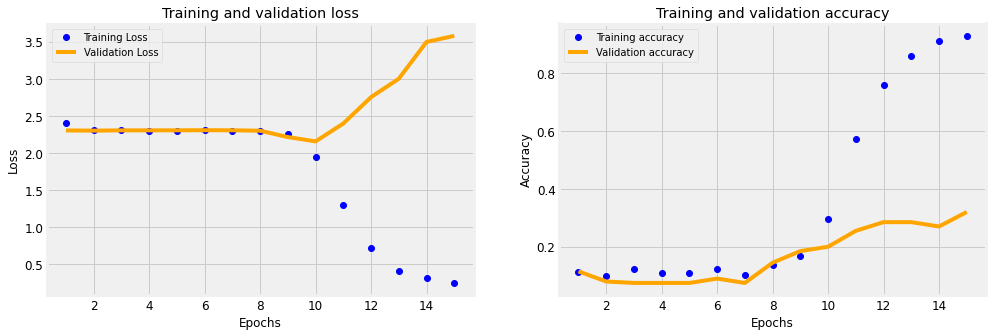

In [46]:
plot_learning_curves_cnn(history)

7/7 [==============================] - 4s 532ms/step


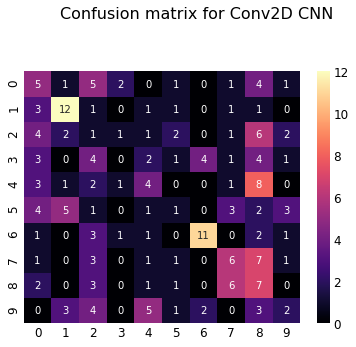

In [47]:
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(CNNmodel.predict(X_test), axis=1)
fig, axs = plt.subplots(1, 1, figsize=(6, 5))


confusion_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_mat, annot=True, cmap='magma', ax=axs, fmt='g')

axs.grid(False)


plt.suptitle(
    f'Confusion matrix for Conv2D CNN',
    fontsize=16)

plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=0.9,
    top=0.8,
    wspace=0.2,
    hspace=0.4)
